In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

from sklearn.compose import ColumnTransformer # fazer a transformação de colunas
from sklearn.dummy import DummyRegressor # regressor padrão para comparação
from sklearn.linear_model import ElasticNet, LinearRegression # modelo de regressão
from sklearn.pipeline import Pipeline # criar pipeline, etapa de processamento
from sklearn.preprocessing import (
    OrdinalEncoder, # variáveis ordinais
    OneHotEncoder, # categóricas
    PolynomialFeatures, # criar variáveis com multiplicação entre ela ou ao quadrado dela mesma 
    PowerTransformer, # transformação em potência (yeo-johnson ou box-cox)
    RobustScaler, 
    StandardScaler, # ajuste de escala das variáveis independentes
    QuantileTransformer, # normaliza os dados em quantis
)

from src.config import DADOS_LIMPOS
from src.auxiliares import dataframe_coeficientes
from src.graficos import (
    plot_coeficientes,
    plot_comparar_metricas_modelos,
    plot_residuos_estimador,
)
from src.models import (
    organiza_resultados,
    treinar_e_validar_modelo_regressao,
    grid_search_cv_regressor,
)

In [2]:
df = pd.read_parquet(DADOS_LIMPOS)

df.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity,median_income_cat,rooms_per_household,population_per_household,bedrooms_per_room
0,-122.230003,37.880001,41,880,129,322,126,8.3252,452600,NEAR BAY,5,6.984127,2.555556,0.146591
1,-122.220001,37.860001,21,7099,1106,2401,1138,8.3014,358500,NEAR BAY,5,6.238137,2.109842,0.155797
2,-122.260002,37.840000,42,2555,665,1206,595,2.0804,226700,NEAR BAY,2,4.294117,2.026891,0.260274
3,-122.260002,37.849998,50,1120,283,697,264,2.1250,140000,NEAR BAY,2,4.242424,2.640152,0.252679
4,-122.260002,37.840000,50,2239,455,990,419,1.9911,158700,NEAR BAY,2,5.343676,2.362768,0.203216


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17564 entries, 0 to 17563
Data columns (total 14 columns):
 #   Column                    Non-Null Count  Dtype   
---  ------                    --------------  -----   
 0   longitude                 17564 non-null  float32 
 1   latitude                  17564 non-null  float32 
 2   housing_median_age        17564 non-null  int8    
 3   total_rooms               17564 non-null  int16   
 4   total_bedrooms            17564 non-null  int16   
 5   population                17564 non-null  int16   
 6   households                17564 non-null  int16   
 7   median_income             17564 non-null  float32 
 8   median_house_value        17564 non-null  int32   
 9   ocean_proximity           17564 non-null  category
 10  median_income_cat         17564 non-null  int64   
 11  rooms_per_household       17564 non-null  float32 
 12  population_per_household  17564 non-null  float32 
 13  bedrooms_per_room         17564 non-null  floa

In [4]:
coluna_target = ["median_house_value"]

coluna_one_hot_encoder = ["ocean_proximity"]

coluna_ordinal_encoder = ["median_income_cat"]

In [5]:
# separando todas as colunas numéricas para realizar uma transformação uniforme
# ele não é tão sensível a outliers
colunas_robust_scaler = df.columns.difference(coluna_target + coluna_one_hot_encoder + coluna_ordinal_encoder)

colunas_robust_scaler

Index(['bedrooms_per_room', 'households', 'housing_median_age', 'latitude',
       'longitude', 'median_income', 'population', 'population_per_household',
       'rooms_per_household', 'total_bedrooms', 'total_rooms'],
      dtype='object')

        A partir do momento em que definimos que um pré-processamento nas colunas numéricas com o RobustScaler é melhor, vamos adotá-lo e buscar otimizar outras coisas. A partir do momento em que percebemos que o QuantileTransformer para transformação de target é melhor que o PowerTransformer, vamos adotá-lo e buscar otimizar outras coisas. Poderíamos ter testado tudo desde o início? Sim, mas a busca por melhores resultados dessa forma pode ser desnecessária em alguns casos, sendo mais vantajoso testar por etapas até achar os melhores parâmetros do modelo.

In [7]:
# o grau inicial da segunda etapa é 1, mas ele será alterado
pipeline_robust = Pipeline(steps=[
    ("robust_scaler", RobustScaler()), # primeira etapa da pipeline
    ("poly", PolynomialFeatures(degree=1, include_bias=False)), # segunda etapa da pipeline 
])

# pré-processamento pegando a pipeline com a transformação de escala e PolynomialFeatures
preprocessamento = ColumnTransformer(
    transformers=[
        ("ordinal_encoder", OrdinalEncoder(categories="auto"), coluna_ordinal_encoder),
        ("one_hot_encoder", OneHotEncoder(drop="first"), coluna_one_hot_encoder),
        ("robust_scaler_poly", pipeline_robust, colunas_robust_scaler) # usando a pipeline transformada
    ],
)

In [8]:
# separando X e y da base de dados
X = df.drop(columns=coluna_target)
y = df[coluna_target]

In [9]:
X.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,ocean_proximity,median_income_cat,rooms_per_household,population_per_household,bedrooms_per_room
0,-122.230003,37.880001,41,880,129,322,126,8.3252,NEAR BAY,5,6.984127,2.555556,0.146591
1,-122.220001,37.860001,21,7099,1106,2401,1138,8.3014,NEAR BAY,5,6.238137,2.109842,0.155797
2,-122.260002,37.840000,42,2555,665,1206,595,2.0804,NEAR BAY,2,4.294117,2.026891,0.260274
3,-122.260002,37.849998,50,1120,283,697,264,2.1250,NEAR BAY,2,4.242424,2.640152,0.252679
4,-122.260002,37.840000,50,2239,455,990,419,1.9911,NEAR BAY,2,5.343676,2.362768,0.203216


In [10]:
y.head()

,median_house_value
0,452600
1,358500
2,226700
3,140000
4,158700


Incluindo os parâmetros de regularização e verificando se o modelo L1(Lasso), L2(Ridge) ou ElasticNet (mistura de L1 e L2) faz mais sentido.

In [12]:
# pegando o grau
param_grid = {
    "regressor__preprocessor__robust_scaler_poly__poly__degree": [1, 2, 3], # grau poly
    "regressor__reg__alpha":[1E-2, 5E-2, 0.1, 0.25, 0.5, 1.0], # penalização
    "regressor__reg__l1_ratio":[0.1, 0.25, 0.5, 0.75, 0.9], # regularização
}

Aplicando o modelo de regressão linear com regularização ElasticNet, para testar as penalizações e se a regularização tende para Ridge ou Lasso, buscando melhorar a compreensão e coeficientes do modelo.

In [14]:
# criando uma pesquisa de grade buscando a melhor combinação entre 
# pré-processamento e transformação que apresenta o melhor resultado 
grid_search = grid_search_cv_regressor(
    regressor=ElasticNet(), # o modelo
    preprocessor=preprocessamento, # pré-processamento
    target_transformer=QuantileTransformer(output_distribution="normal"), # transformação no target
    param_grid=param_grid, # grau, penalização e regularização
)

grid_search

GridSearchCV(cv=KFold(n_splits=5, random_state=42, shuffle=True),
             estimator=TransformedTargetRegressor(regressor=Pipeline(steps=[('preprocessor',
                                                                             ColumnTransformer(transformers=[('ordinal_encoder',
                                                                                                              OrdinalEncoder(),
                                                                                                              ['median_income_cat']),
                                                                                                             ('one_hot_encoder',
                                                                                                              OneHotEncoder(drop='first'),
                                                                                                              ['ocean_proximity']),
                                                                                                             ('robust_scaler_poly',
                                                                                                              Pipeline(steps=[('robust_sc...
                                                  transformer=QuantileTransformer(output_distribution='normal')),
             n_jobs=-1,
             param_grid={'regressor__preprocessor__robust_scaler_poly__poly__degree': [1,
                                                                                       2,
                                                                                       3],
                         'regressor__reg__alpha': [0.01, 0.05, 0.1, 0.25, 0.5,
                                                   1.0],
                         'regressor__reg__l1_ratio': [0.1, 0.25, 0.5, 0.75,
                                                      0.9]},
             refit='neg_root_mean_squared_error',
             scoring=['r2', 'neg_mean_absolute_error',
                      'neg_root_mean_squared_error'],
             verbose=1)

        A partir do momento que foi definido que um pré-processamento 

In [16]:
# treinando o grid_search
grid_search.fit(X, y)

Fitting 5 folds for each of 90 candidates, totalling 450 fits


C:\Users\barbo\anaconda3\envs\aprendizado_maquina\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.545e+02, tolerance: 1.808e+00
  model = cd_fast.enet_coordinate_descent(


GridSearchCV(cv=KFold(n_splits=5, random_state=42, shuffle=True),
             estimator=TransformedTargetRegressor(regressor=Pipeline(steps=[('preprocessor',
                                                                             ColumnTransformer(transformers=[('ordinal_encoder',
                                                                                                              OrdinalEncoder(),
                                                                                                              ['median_income_cat']),
                                                                                                             ('one_hot_encoder',
                                                                                                              OneHotEncoder(drop='first'),
                                                                                                              ['ocean_proximity']),
                                                                                                             ('robust_scaler_poly',
                                                                                                              Pipeline(steps=[('robust_sc...
                                                  transformer=QuantileTransformer(output_distribution='normal')),
             n_jobs=-1,
             param_grid={'regressor__preprocessor__robust_scaler_poly__poly__degree': [1,
                                                                                       2,
                                                                                       3],
                         'regressor__reg__alpha': [0.01, 0.05, 0.1, 0.25, 0.5,
                                                   1.0],
                         'regressor__reg__l1_ratio': [0.1, 0.25, 0.5, 0.75,
                                                      0.9]},
             refit='neg_root_mean_squared_error',
             scoring=['r2', 'neg_mean_absolute_error',
                      'neg_root_mean_squared_error'],
             verbose=1)

        Como o ElasticNet é uma combinação do Ridge e do Lasso, ele pode ser um pouco mais demorado para o treinamento, porque consome um pouco mais de recursos, podendo levar alguns minutos.

In [18]:
grid_search.best_params_

{'regressor__preprocessor__robust_scaler_poly__poly__degree': 3,
 'regressor__reg__alpha': 0.01,
 'regressor__reg__l1_ratio': 0.1}

        Com a busca em grade o melhor grau foi definido com o 3, a penalização foi baixa com 0.01, e a regularização l1_ratio teve 0.1, bem próximo de zero, indicando que vale a pena testar o Ridge.

In [20]:
# métrica RMSE (Root Mean Square Error - raiz do erro quadrático médio)
# é a métrica de desempate no refit de validação cruzada da função grid_search_cv_regressor
grid_search.best_score_

np.float64(-51305.17079054054)

        O RMSE não apresentou melhora comparado com o modelo anterior, é interessante colocar os dois notebooks para comparação dividindo a tela. Isso teve para comparação o modelo anterior com aproximadamente a métrica RMSE na faixa de -51140.

In [22]:
coefs = dataframe_coeficientes(
    grid_search.best_estimator_.regressor_["reg"].coef_,
    grid_search.best_estimator_.regressor_["preprocessor"].get_feature_names_out()
)

coefs

,coeficiente
one_hot_encoder__ocean_proximity_INLAND,-0.607319
robust_scaler_poly__longitude,-0.382661
robust_scaler_poly__population_per_household,-0.343840
robust_scaler_poly__latitude,-0.218033
robust_scaler_poly__latitude^2,-0.192641
...,...
ordinal_encoder__median_income_cat,0.093150
robust_scaler_poly__housing_median_age longitude^2,0.113527
robust_scaler_poly__bedrooms_per_room,0.130093
robust_scaler_poly__housing_median_age median_income,0.180542


        Apesar da quantidade de coeficientes ser bem grande, a faixa entre eles ficou menor.

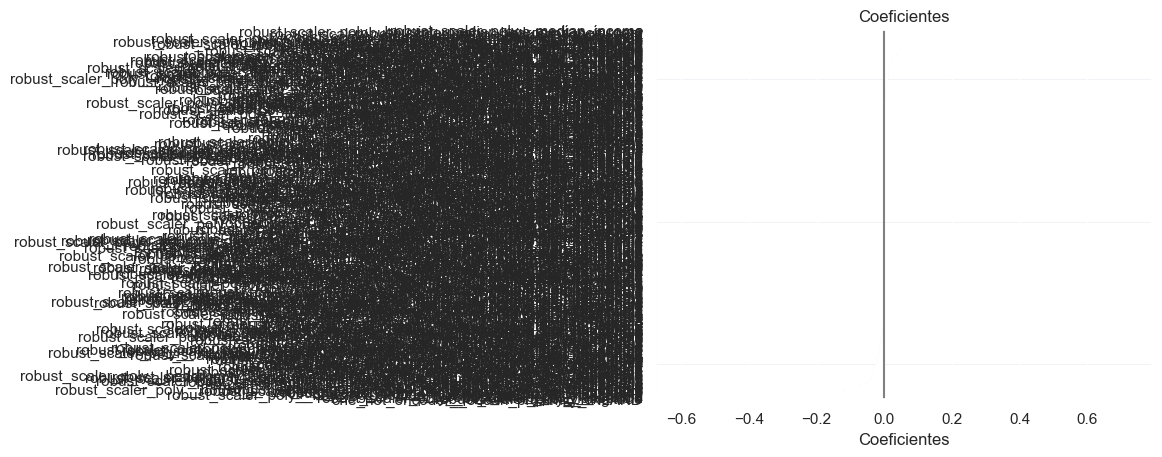

In [24]:
# criando um gráfico com os coeficientes
plot_coeficientes(coefs)

    Conforme foram criados uma quantidade massiva de coeficientes comparados com a quantidade de features iniciais, é impossível gerar um gráfico com os coeficientes, pois existe sobreposição que dificulta na interpretação e explicação dos resultados.

In [26]:
# verificando se existem coeficientes nulos
coefs[coefs["coeficiente"] == 0]

,coeficiente
robust_scaler_poly__bedrooms_per_room households housing_median_age,-0.0
robust_scaler_poly__population rooms_per_household^2,0.0
robust_scaler_poly__population rooms_per_household total_bedrooms,-0.0
robust_scaler_poly__population rooms_per_household total_rooms,-0.0
robust_scaler_poly__population total_bedrooms^2,-0.0
...,...
robust_scaler_poly__median_income population rooms_per_household,0.0
robust_scaler_poly__median_income population total_rooms,0.0
robust_scaler_poly__longitude median_income rooms_per_household,-0.0
robust_scaler_poly__longitude median_income total_bedrooms,0.0


        Como foi inserida, por mais que pequena, a regularização Lasso, alguns dos coeficientes ficaram zerados, totalizando 211.

In [28]:
# verificando os coeficientes dentro de uma determinada faixa para eliminar coeficientes muito pequenos
# verificando os coeficientes entre -0.1 e 0.1
coefs[coefs["coeficiente"].between(-0.1, 0.1)]

,coeficiente
robust_scaler_poly__bedrooms_per_room^2 median_income,-0.084339
robust_scaler_poly__bedrooms_per_room^2 latitude,-0.073782
robust_scaler_poly__median_income^2,-0.072567
robust_scaler_poly__housing_median_age latitude,-0.070247
robust_scaler_poly__median_income population_per_household,-0.058410
...,...
robust_scaler_poly__total_bedrooms,0.076850
robust_scaler_poly__housing_median_age population_per_household^2,0.085507
robust_scaler_poly__housing_median_age,0.086698
robust_scaler_poly__median_income total_bedrooms,0.091507


        Dentre todos os coeficientes, 352 deles estão dentro do intervalo de -0.1 e 0.1.

In [30]:
coefs[coefs["coeficiente"].between(-0.1, 0.1) & coefs["coeficiente"] != 0]

,coeficiente
robust_scaler_poly__bedrooms_per_room^2 median_income,-0.084339
robust_scaler_poly__bedrooms_per_room^2 latitude,-0.073782
robust_scaler_poly__median_income^2,-0.072567
robust_scaler_poly__housing_median_age latitude,-0.070247
robust_scaler_poly__median_income population_per_household,-0.058410
...,...
robust_scaler_poly__total_bedrooms,0.076850
robust_scaler_poly__housing_median_age population_per_household^2,0.085507
robust_scaler_poly__housing_median_age,0.086698
robust_scaler_poly__median_income total_bedrooms,0.091507


        No intervalo de -0.1 e 0.1 diferentes de zero alguns coeficientes tem um valor relativamente pequeno, indicando que talvez aquela feature não tenha um papel tão grande para o target.

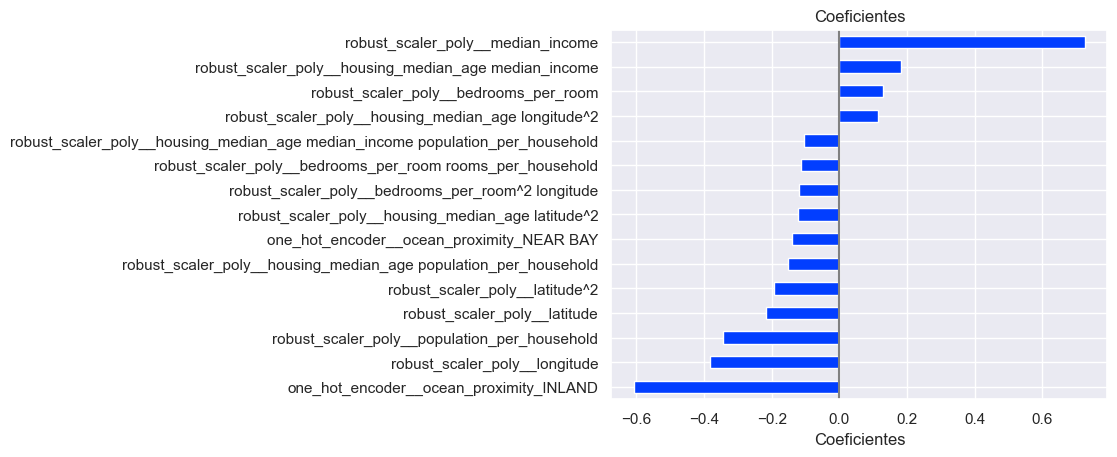

In [32]:
# criando um gráfico com os coeficientes fora da faixa estabelecida acima
# usando o operador negativo para pegar todos os coeficientes dentro da faixa e diferentes de zero
plot_coeficientes(coefs[~coefs["coeficiente"].between(-0.1, 0.1) & coefs["coeficiente"] != 0])

        Agora temos apenas 15 coeficientes, deixando o gráfico mais limpo e menos complicado de avaliar. A partir da regularização imposta, voltamos a ter `median_income` sendo o coeficiente positivo que mais sobressai, nos coeficientes negativos o ocen_proximity, latitude e longitude voltam a se destacar. Com isso, é interessante comparar com o gráfico de coeficientes anterior, registrado no notebook 04-jb-modelo_parte_3 ou anteriores colocando-os lado a lado para tirar dúvidas. No cenário atual, a renda, a idade do imóvel e a localização dele impactam bastante no valor do imóvel.

In [34]:
# comparando os processamentos entre os modelos
regressors = {
    "DummyRegressor":{
        "preprocessor": None,
        "regressor": DummyRegressor(strategy="mean"),
        "target_transformer": None,
    },
    
    "LinearRegression":{
        "preprocessor": preprocessamento,
        "regressor": LinearRegression(),
        "target_transformer": None,
    },
   
    "LinearRegression_target":{
        "preprocessor": preprocessamento,
        "regressor": LinearRegression(),
        "target_transformer": QuantileTransformer(output_distribution="normal"),
    },
   
    "ElasticNet_grid_search":{
        "preprocessor": grid_search.best_estimator_.regressor_["preprocessor"],
        "regressor": grid_search.best_estimator_.regressor_["reg"],
        "target_transformer": grid_search.best_estimator_.transformer_,
    },
}

# criando um dicionário com os resultados dos modelos
resultados = {
    nome_modelo: treinar_e_validar_modelo_regressao(X, y, **regressor)
    for nome_modelo, regressor in regressors.items()
}

# transformando o dicionário dos resultados em DataFrame
df_resultados = organiza_resultados(resultados)

df_resultados

C:\Users\barbo\anaconda3\envs\aprendizado_maquina\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.185e+01, tolerance: 1.443e+00
  model = cd_fast.enet_coordinate_descent(
C:\Users\barbo\anaconda3\envs\aprendizado_maquina\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.506e+01, tolerance: 1.417e+00
  model = cd_fast.enet_coordinate_descent(
C:\Users\barbo\anaconda3\envs\aprendizado_maquina\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the featu

,model,fit_time,score_time,test_r2,test_neg_mean_absolute_error,test_neg_root_mean_squared_error,time_seconds
0,DummyRegressor,0.003001,0.002003,-0.000081,-77516.042766,-96239.705692,0.005003
1,DummyRegressor,0.002034,0.002,-0.000146,-75787.787194,-95217.629397,0.004034
2,DummyRegressor,0.002,0.002,-0.001737,-76753.598961,-96253.253947,0.003999
3,DummyRegressor,0.001508,0.00201,-0.000101,-76837.804811,-95983.885799,0.003518
4,DummyRegressor,0.001,0.002001,-0.000114,-76617.245449,-96182.764729,0.003
5,LinearRegression,0.019249,0.006502,0.682162,-39855.690996,-54254.958188,0.025751
6,LinearRegression,0.020174,0.006509,0.66999,-40272.565467,-54695.230283,0.026683
7,LinearRegression,0.020024,0.006997,0.649247,-42178.05929,-56955.988706,0.02702
8,LinearRegression,0.020532,0.006007,0.669873,-40806.492497,-55146.318803,0.026539
9,LinearRegression,0.017016,0.00701,0.669023,-40788.496497,-55331.35106,0.024027


            O warning apresentado indica que o modelo não passou por iterações suficientes para estabilizar o valor, a quantidade de iterações padrão do ElasticNet são 1.000 iterações, mas 1.000 iterações não parecem ser o suficiente , tendo em vista evitar um underfiting, temos que aumentar o número de iterações para 2.000 ou mais para tentar estabilizar o valor e extinguir esse warning. Mesmo o modelo sem ter estabilizado, ele apresenta resultados melhores do que tínhamos.

In [36]:
# agrupando por modelo e apresentando a média de cada variável, ordenando pelo RMSE
df_resultados.groupby("model").mean().sort_values(by="test_neg_root_mean_squared_error")

,fit_time,score_time,test_r2,test_neg_mean_absolute_error,test_neg_root_mean_squared_error,time_seconds
model,,,,,,
DummyRegressor,0.001908,0.002003,-0.000436,-76702.495836,-95975.447913,0.003911
LinearRegression,0.019399,0.006605,0.668059,-40780.26095,-55276.769408,0.026004
LinearRegression_target,0.024127,0.007517,0.677945,-38680.0947,-54443.372754,0.031645
ElasticNet_grid_search,2.718106,0.015615,0.713705,-36005.289042,-51324.541315,2.733721


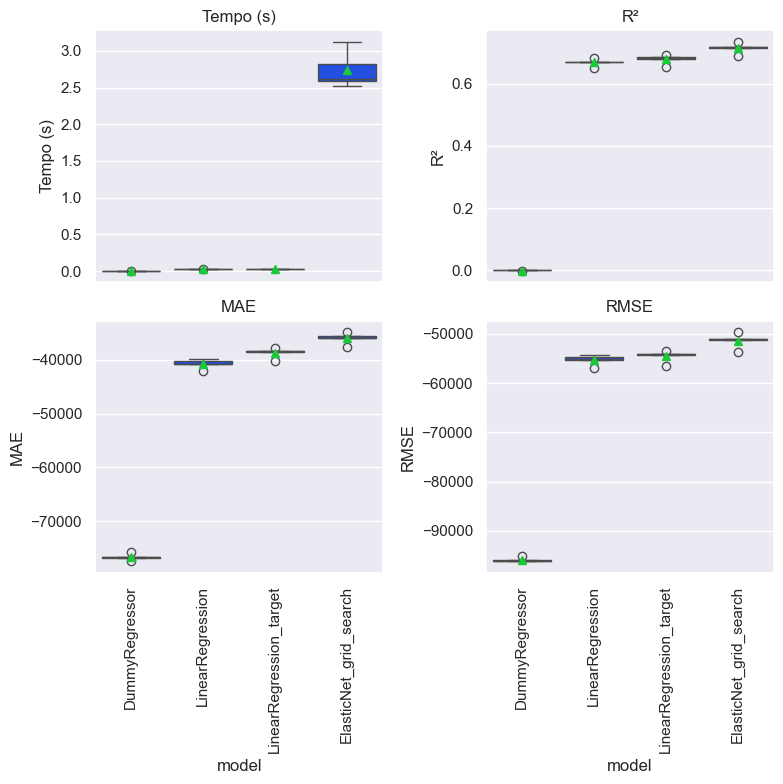

In [37]:
# criando um gráfico com a comparação dos modelos
plot_comparar_metricas_modelos(df_resultados)

        Apesar da melhora nos coeficientes, o tempo de treinamento está bem elevado, como o ElasticNet teve uma valor baixo puxando para o Ridge, é interessante testar o Ridge para saber se o modelo consegue  melhorar as métricas em menos tempo, tendo em vista que o ElasticNet é demorado por ser uma mistura de Ridge e Lasso, consumindo bastante recursos computacionais para sua execução.

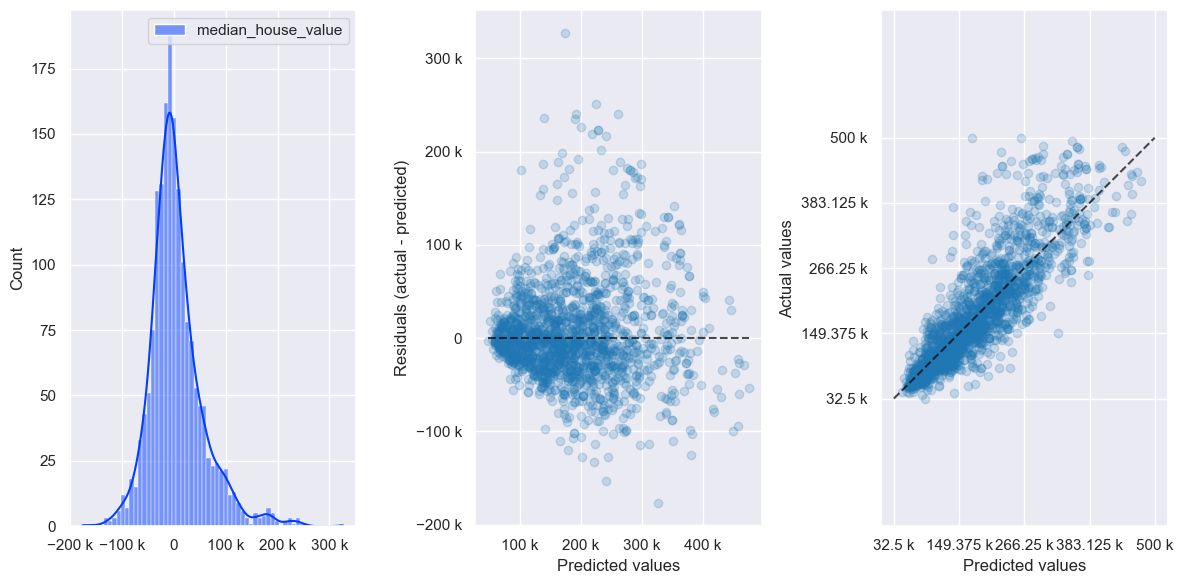

In [39]:
# verificando os resíduos
plot_residuos_estimador(grid_search.best_estimator_, X, y, fracao_amostra=0.1, eng_formatter=True)

        Nosso modelo continua errando para menos, com valores até 300.000, mesmo assim a maior concentração de pontos está próximo de zero, mas, aparentemente, o modelo começou a errar menos já que a concentração de pontos altos parece ter diminuído.